# First mount Google Drive, so you have access to the Car notebook

In [ ]:
from google.colab import drive
drive.mount("mnt")

%cd "mnt/My Drive/Colab Notebooks"

Mounted at mnt
/content/mnt/My Drive/Colab Notebooks


# Install ipynb package

In [ ]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=a65ed1a9927033beeff638d385b51b1e9c72d14e3738de1360ebcfafb05a1e16
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


# Set up Car world (with state feedack)

In [ ]:
import os
import sys

from Car import World
from Car import square_hall_right

# hallway dimensions
hall_width = 2
hall_length = 30

# car starting position and velocity
car_dist_s = 1 # distance to left wall
car_dist_f = 28 # distance to front wall
car_heading = 0 # relative to walls
car_V = 2.4

# constant car throttle
throttle = 16

# car dynamics noise
init_pos_noise = 0
init_heading_noise = 0
front_pos_noise = 0

episode_length = 100
time_step = 0.1

# set this to false if you'd like to use lidar
state_feedback = True

# lidar parameters
lidar_field_of_view = 115
lidar_num_rays = 21

# various lidar settings
lidar_noise = 0
missing_lidar_rays = 0
lidar_missing_in_turn_only = False

# set up a square hallway with right turns
(hallWidths, hallLengths, turns) = square_hall_right(hall_width, hall_length)

# create the environment
w = World(hallWidths, hallLengths, turns,\
          car_dist_s, car_dist_f, car_heading, car_V,\
          episode_length, time_step, lidar_field_of_view,\
          lidar_num_rays, lidar_noise, missing_lidar_rays,\
          lidar_missing_in_turn_only, state_feedback=state_feedback)

importing Jupyter notebook from Car.ipynb


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Plot Lidar

This is just an example illustrating how to plot LiDAR in case you need to

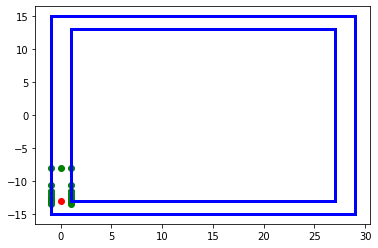

In [ ]:
w.plot_lidar()

# PID Controller

In [ ]:
def pid_control(error, int_error, d_error):

    proportional_gain = 10
    integral_gain = 0.1
    derivative_gain = 8

    #multiply error by constant
    Up = proportional_gain * error
    #multiply error by integral - (response to error accumulated over time)
    Ui = integral_gain * int_error
    #multiply error by derivative
    Ud= derivative_gain * d_error
    #derivative error is equal to (current error - previous error )/time response to current rate of change of error

    #add together into variable "u"
    u = Up + Ui + Ud

    return u

# Control Loop

In [ ]:
#choose different gains for the lidar
def pid_control(error, int_error, d_error):

    proportional_gain = 10
    integral_gain = 0.1
    derivative_gain = 8

    #multiply error by constant
    Up = proportional_gain * error
    #multiply error by integral - (response to error accumulated over time)
    Ui = integral_gain * int_error
    #multiply error by derivative
    Ud= derivative_gain * d_error
    #derivative error is equal to (current error - previous error )/time response to current rate of change of error

    #add together into variable "u"
    u = Up + Ui + Ud

    return u

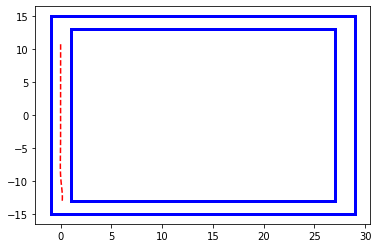

In [ ]:
''' observation is an array of 5 elements:
[distance to left wall,
distance to right wall,
distance to front wall,
distance to turn,
heading w.r.t hallway]
'''

# initial position noise parameters
side_pos_noise = 0.25
heading_noise = 0.1
front_pos_noise = 0

# reset the environment
observation = w.reset(pos_noise=side_pos_noise, heading_noise=heading_noise, front_pos_noise=front_pos_noise)


# your code goes here and in the loop below
pos_reference = 1
err = observation[0] - 1
int_err = 0
d_err = 0

delta = pid_control(err, int_err, d_err)

for e in range(episode_length):
    observation, reward, done, info = w.step(delta, throttle)
    delta = pid_control(err, int_err, d_err)
    int_err += err
    new_err = observation[0] - 1
    d_err = (new_err-err)/0.1
    err = new_err

    if done:
        if e < episode_length - 1:
          print('Unsafe!')
          break

w.plot_trajectory()


# Set up Car world (with lidar feedback)

This code is reusing variables from above, so make sure you run those cells first

In [ ]:
# Set this to false if you'd like to use lidar
state_feedback = False

w_true = World(hallWidths, hallLengths, turns,\
          car_dist_s, car_dist_f, car_heading, car_V,\
          episode_length, time_step, lidar_field_of_view,\
          lidar_num_rays, lidar_noise, missing_lidar_rays,\
          lidar_missing_in_turn_only, state_feedback=state_feedback)

throttle = 16

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Control and Estimation loop

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


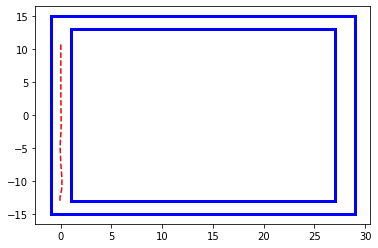

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

# PARTICLE FILTER PARAMETERS
# initialize particles
num_particles = 100

# initial noise parameters
initial_x_noise = 0.3
initial_y_noise = 0.3
initial_theta_noise = 0.1

# dynamics noise parameters
x_dynamics_noise = 0.05
y_dynamics_noise = 0.05
v_dynamics_noise = 0.01
theta_dynamics_noise = 0.01

observation = w_true.reset()

# initialize data holders
allX = []
allY = []
allTheta = []
allLidar = []
allV = []
allTimes = []
allParticles = []

# create particles
particle_list = []
for i in range(num_particles):

    init_x = car_dist_s + initial_x_noise * (2 * np.random.random() - 1)
    init_y = car_dist_f + initial_x_noise * (2 * np.random.random() - 1)
    init_theta = car_heading + initial_theta_noise * (2 * np.random.random() - 1)

    w = World(hallWidths, hallLengths, turns,\
              init_x, init_y, init_theta, car_V,\
              episode_length, time_step, lidar_field_of_view,\
              lidar_num_rays, lidar_noise, missing_lidar_rays)

    particle_list.append(w)

allParticles.append(particle_list)

# your code goes here and in the loop below
pos_reference = 1
err = observation[0] - 1
int_err = 0
d_err = 0
particle_weights = [1/num_particles for i in range(num_particles)]




delta = pid_control(err, int_err, d_err)

for e in range(episode_length):

    observation, reward, done, info = w_true.step(delta, throttle)
    true_scan = w_true.scan_lidar()
    # compute particle weights
        #implement gaussian pdf and set weights based on distance to measurement
        #we want to calculate difference between particle lidar scan and our actual lidar scan
        #multiply previous weights by current weights to create new weights
    multivar_weights = []
    for p in allParticles[0]:
        weights = multivariate_normal.pdf(p.scan_lidar(), true_scan)
        multivar_weights.append(weights)
    for i in range(len(allParticles[0])):
        particle_weights[i] *= multivar_weights[i]

    # normalize weights
        #normalize weights to sum up to 1

    particle_weights /= sum(particle_weights)
    #print(particle_weights)
    #print(sum(particle_weights))
    # resample particles
        #remove low probability particles from the system based on their weights
        #resample particles to fit the distribution so that their weights are equal again
    resampled_particles = []
    for i in range(num_particles):
        resampled_particles.append(copy.deepcopy(np.random.choice(allParticles[0], p=particle_weights, replace=True)))
    allParticles[0] = resampled_particles
    # compute state estimates and errors for the pid controller
        # average position and heading of all particles
    avg_dist = 0
    avg_heading = 0
    for p in allParticles[0]:
        avg_dist += p.car_dist_s
        avg_heading += p.car_heading

    avg_dist /= num_particles
    avg_heading /= num_particles


    delta = pid_control(err, int_err, d_err)

    int_err += err
    new_err = avg_dist - 1
    d_err = (new_err-err)/0.1
    err = new_err


    # progress particles
        #predict where each particle would move if they followed the same path as the car
    for p in allParticles[0]:
        p.step(delta, throttle)


    # break if done
    if done:
        if e < episode_length - 1:
          #print('Unsafe!')
          #break
          pass

# plot trajectories
fig = plt.figure()
w_true.plotHalls()

# true trajectory
plt.plot(w_true.allX, w_true.allY, 'r--')

# estimated trajectory
plt.plot(allX, allY, 'g--')